AIN311 CLASS PROJECT

MELİKE NUR DULKADİR & SARE NAZ ERSOY

# Career Path Predictor

Importing necessary libraries

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import tree,svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
sns.set(style="white")
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from pandas.core.common import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [98]:
df = pd.read_csv('https://raw.githubusercontent.com/Umang-19/devjam/main/public/mldata.csv')
df.head()

,Logical quotient rating,hackathons,coding skills rating,public speaking points,self-learning capability?,Extra-courses did,certifications,workshops,reading and writing skills,memory capability score,Interested subjects,interested career area,Type of company want to settle in?,Taken inputs from seniors or elders,Interested Type of Books,Management or Technical,hard/smart worker,worked in teams ever?,Introvert,Suggested Job Role
0,5,0,6,2,yes,no,information security,testing,poor,poor,programming,testing,BPA,no,Series,Management,smart worker,yes,no,Applications Developer
1,7,6,4,3,no,yes,shell programming,testing,excellent,medium,Management,system developer,Cloud Services,yes,Autobiographies,Technical,hard worker,no,yes,Applications Developer
2,2,3,9,1,no,yes,information security,testing,excellent,poor,data engineering,Business process analyst,product development,yes,Travel,Technical,smart worker,no,no,Applications Developer
3,2,6,3,5,no,yes,r programming,database security,excellent,poor,networks,testing,Testing and Maintainance Services,yes,Guide,Management,smart worker,yes,yes,Applications Developer
4,2,0,3,4,yes,no,distro making,game development,excellent,medium,Software Engineering,system developer,BPA,no,Health,Technical,hard worker,yes,no,Applications Developer


Some utils functions for understand the data clearly

In [99]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("##################### Properties #####################")
    print(df.describe())

In [100]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                Class threshold for numeric but categorical variables
        car_th: int, optinal
                Class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                Categorical view cardinal variable list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat inside cat_cols.
        The sum of the 3 returned lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    #num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th anddataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    #cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    #num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
   # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [101]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [102]:
def replace_with_thresholds(dataframe, variable, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1, q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [103]:
def check_outlier(dataframe, col_name, q1=.25, q3=.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [104]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [105]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

In [106]:
check_df(df)

##################### Shape #####################
(6901, 20)
##################### Types #####################
Logical quotient rating                 int64
hackathons                              int64
coding skills rating                    int64
public speaking points                  int64
self-learning capability?              object
Extra-courses did                      object
certifications                         object
workshops                              object
reading and writing skills             object
memory capability score                object
Interested subjects                    object
interested career area                 object
Type of company want to settle in?     object
Taken inputs from seniors or elders    object
Interested Type of Books               object
Management or Technical                object
hard/smart worker                      object
worked in teams ever?                  object
Introvert                              object
Suggested Job R

In [107]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 6901
Variables: 20
cat_cols: 15
num_cols: 4
cat_but_car: 1


In [108]:
num_cols

['Logical quotient rating',
 'hackathons',
 'coding skills rating',
 'public speaking points']

In [109]:
for col in num_cols:
    print(check_outlier(df,col))

False
False
False
False


<AxesSubplot:>

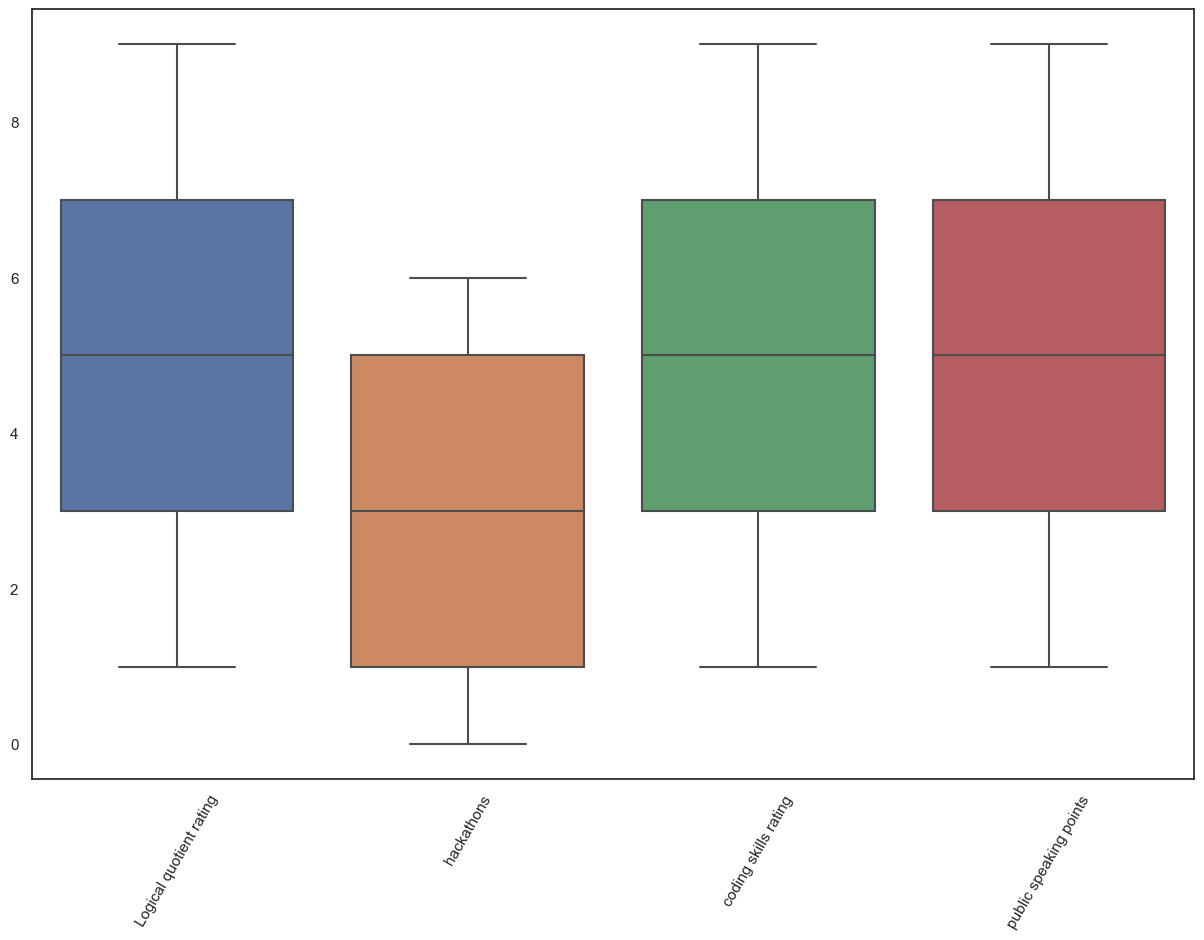

In [110]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
sns.boxplot(data=df[num_cols], ax=ax)

In [111]:
print("\n######## List of Categorical features ########\n")
for index,col in enumerate(cat_cols):
    print(index,col)


######## List of Categorical features ########

0 self-learning capability?
1 Extra-courses did
2 certifications
3 workshops
4 reading and writing skills
5 memory capability score
6 Interested subjects
7 interested career area 
8 Type of company want to settle in?
9 Taken inputs from seniors or elders
10 Management or Technical
11 hard/smart worker
12 worked in teams ever?
13 Introvert
14 Suggested Job Role


In [112]:
for i in cat_cols:
    print(df[i].value_counts(), end="\n\n")

yes    3496
no     3405
Name: self-learning capability?, dtype: int64

no     3529
yes    3372
Name: Extra-courses did, dtype: int64

r programming           803
information security    785
shell programming       783
machine learning        783
full stack              768
hadoop                  764
python                  756
distro making           740
app development         719
Name: certifications, dtype: int64

database security    897
system designing     891
web technologies     891
hacking              867
testing              852
data science         842
game development     831
cloud computing      830
Name: workshops, dtype: int64

excellent    2328
medium       2315
poor         2258
Name: reading and writing skills, dtype: int64

medium       2317
excellent    2303
poor         2281
Name: memory capability score, dtype: int64

Software Engineering     731
IOT                      722
cloud computing          721
programming              716
networks                 713
C

In [113]:
label_encoder = LabelEncoder()
for cat_col in cat_cols:
    df[cat_col]= label_encoder.fit_transform(df[cat_col])

In [114]:
df.head()

,Logical quotient rating,hackathons,coding skills rating,public speaking points,self-learning capability?,Extra-courses did,certifications,workshops,reading and writing skills,memory capability score,Interested subjects,interested career area,Type of company want to settle in?,Taken inputs from seniors or elders,Interested Type of Books,Management or Technical,hard/smart worker,worked in teams ever?,Introvert,Suggested Job Role
0,5,0,6,2,1,0,4,6,2,2,9,5,0,0,Series,0,1,1,0,0
1,7,6,4,3,0,1,8,6,0,1,2,4,1,1,Autobiographies,1,0,0,1,0
2,2,3,9,1,0,1,4,6,0,2,5,0,9,1,Travel,1,1,0,0,0
3,2,6,3,5,0,1,7,2,0,2,7,5,7,1,Guide,0,1,1,1,0
4,2,0,3,4,1,0,1,3,0,1,3,4,0,0,Health,1,0,1,0,0


<AxesSubplot:>

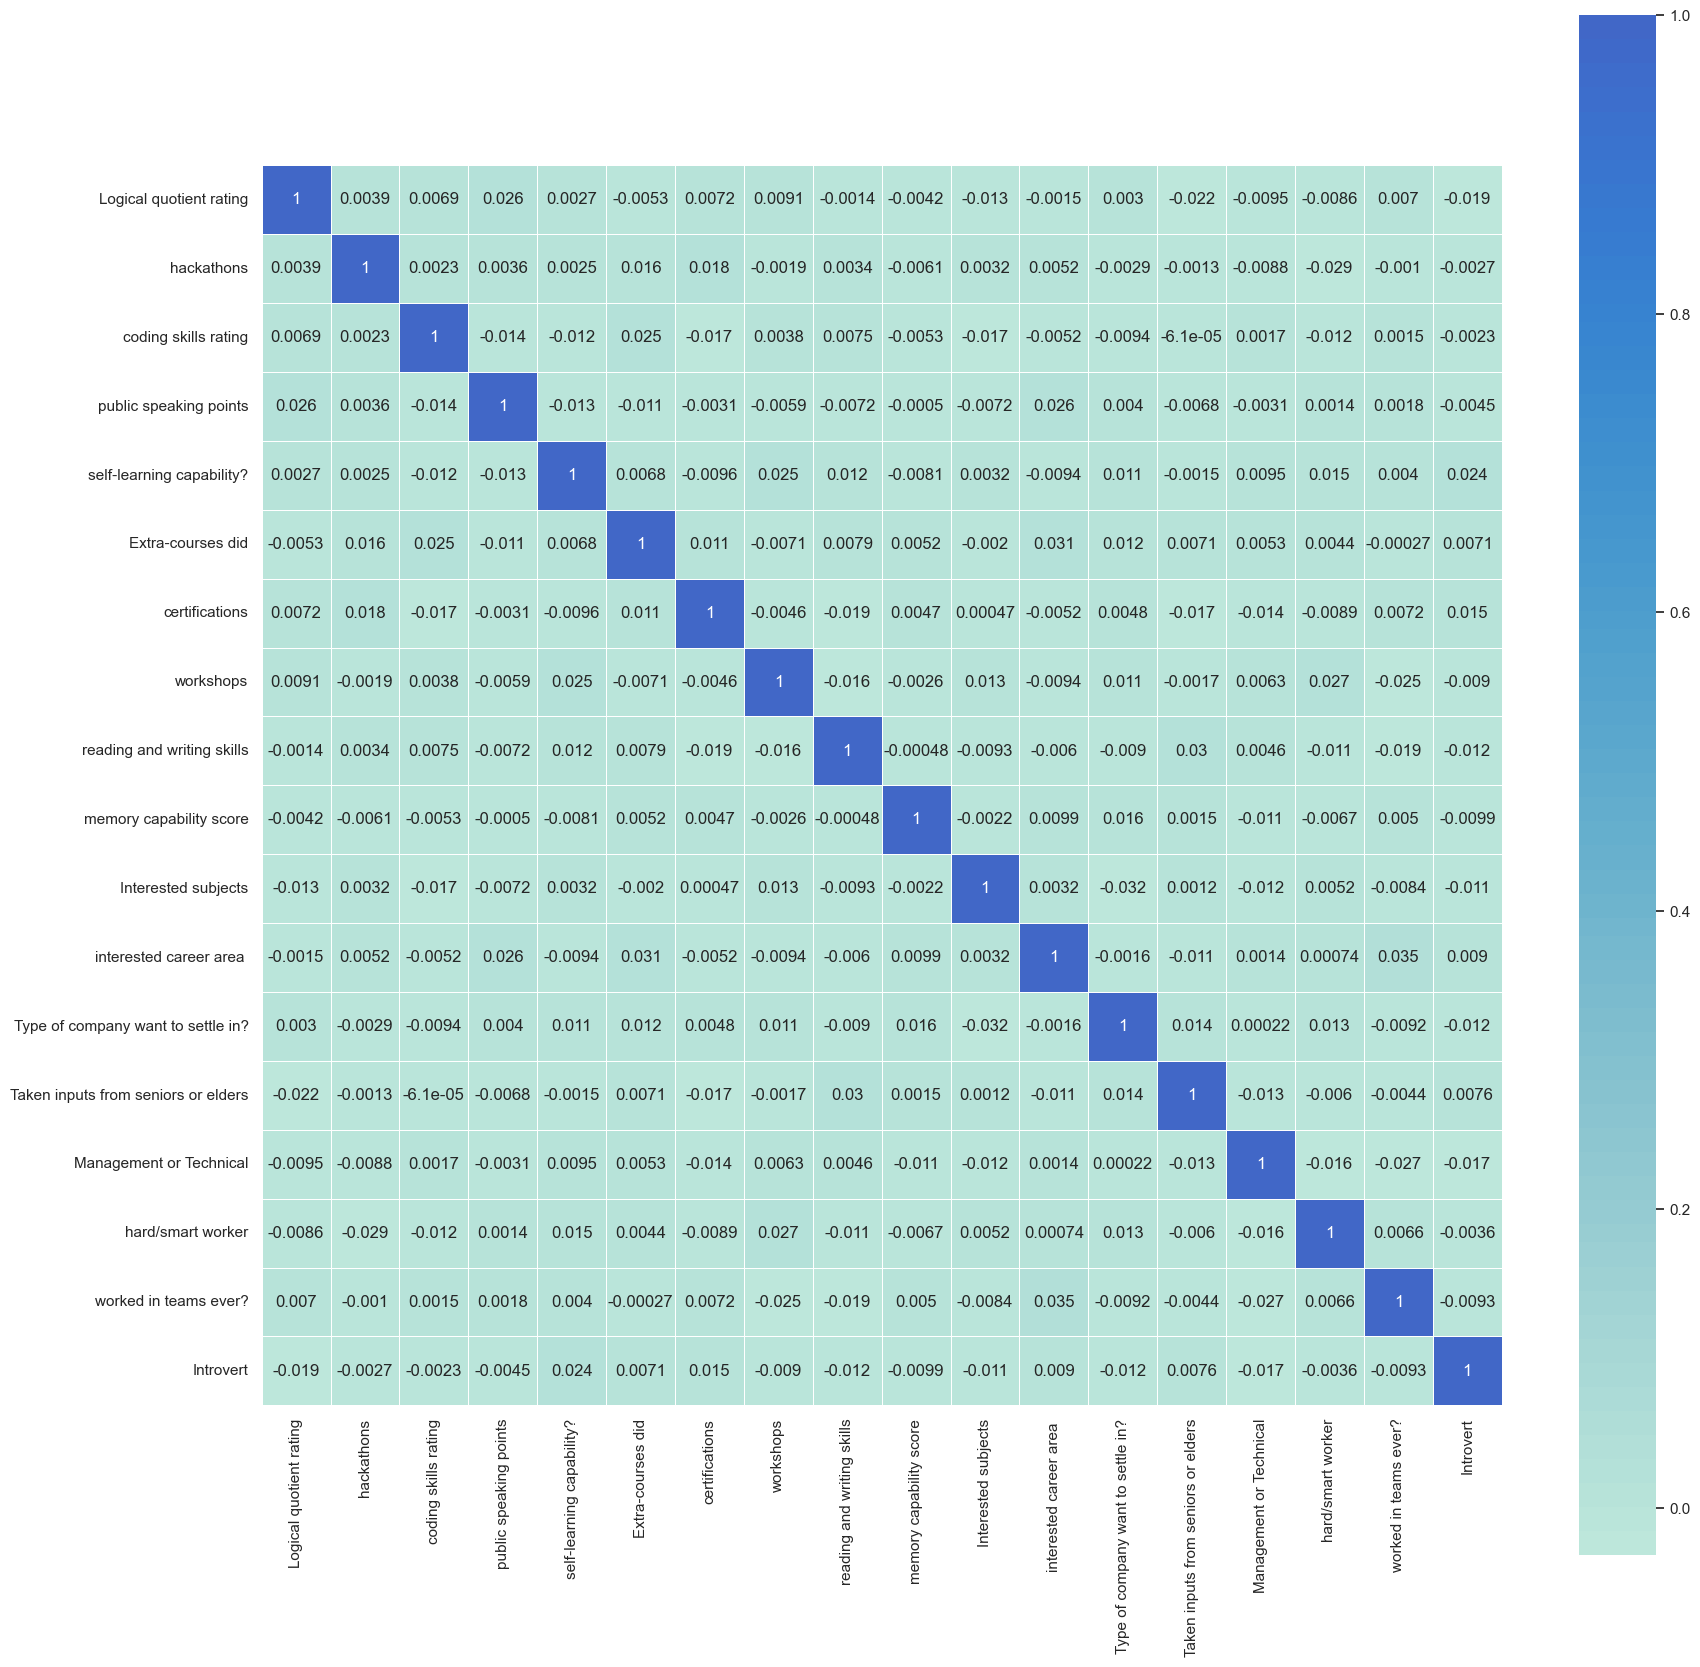

In [115]:
df3 = df.drop(columns = ["Suggested Job Role"])
df3 = df3.corr()
f,axes = plt.subplots(1,1,figsize = (20,20))
sns.heatmap(df3,square=True,annot = True,linewidth = .4,center = 2,ax = axes)

No highly corelated numerical pair found.

In [127]:
pca = PCA()
pca.fit(df3)
PC_components = np.arange(pca.n_components_) + 1

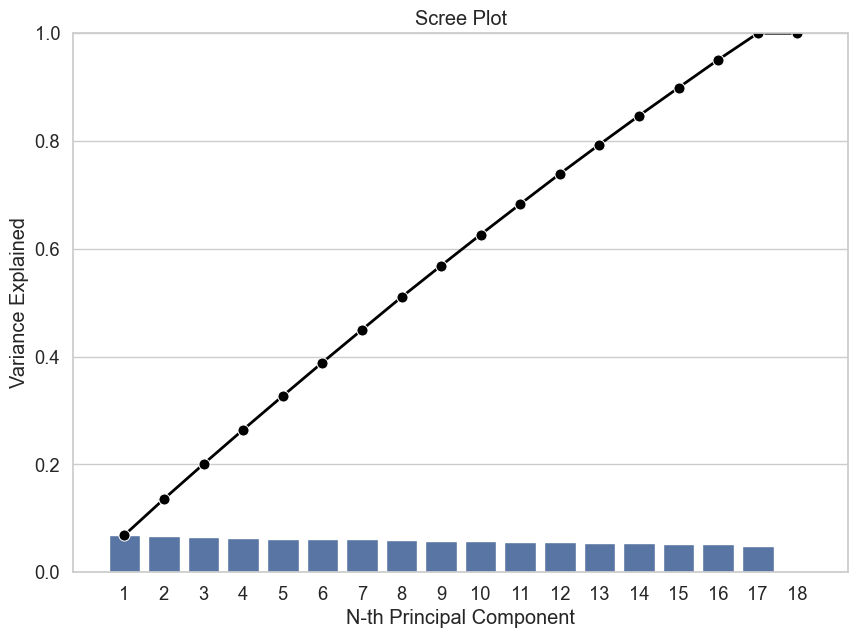

In [128]:
# Scree Plot
scree_plot = sns.set(style='whitegrid', font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 7))
scree_plot = sns.barplot(x=PC_components, y=pca.explained_variance_ratio_, color='b')
scree_plot = sns.lineplot(x=PC_components-1, y=np.cumsum(pca.explained_variance_ratio_), color='black', linestyle='-', linewidth=2, marker='o', markersize=8)

plt.title('Scree Plot')
plt.xlabel('N-th Principal Component')
plt.ylabel('Variance Explained')
plt.ylim(0, 1)
plt.show()
#As you see after 18 feature relation, there is no change in data explainability.
#Which means we can use 18 feature to explain our data.

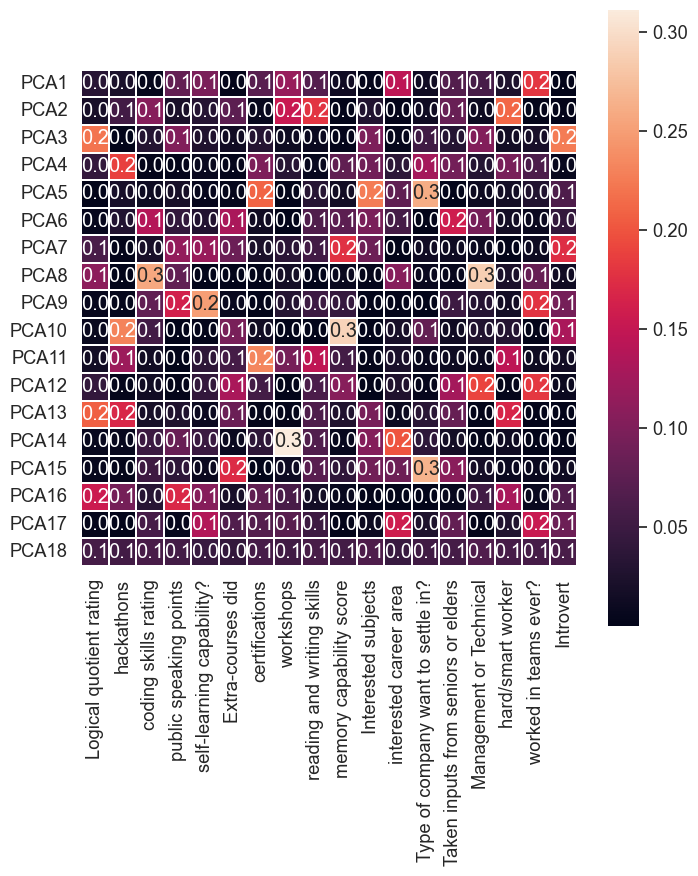

In [118]:
# Feature Weight
fig, ax = plt.subplots(figsize=(8,8))
feature_weight = sns.heatmap(pca.components_**2,
                yticklabels=["PCA"+str(x) for x in range(1,pca.n_components_+1)],
                xticklabels=(df3.columns),
                ax = ax,
                annot=True,
                fmt='.1f',
                square=True,
                linewidths=0.05,
                cbar_kws={"orientation": "vertical"})

So, we can re-run the PCA model, but this time with the n_components=18 argument, which tells the PCA to keep only the top 18 principal components for us.

In [119]:
pca = PCA(n_components=18)

In [120]:
pca.fit(df3)
PC_components = np.arange(pca.n_components_) + 1

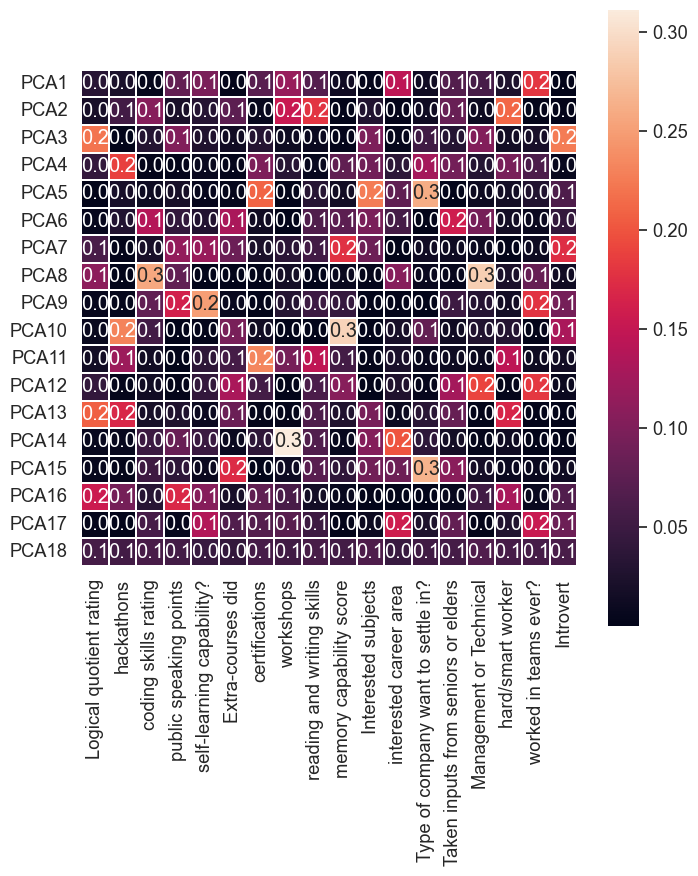

In [121]:
# Feature Weight
fig, ax = plt.subplots(figsize=(8,8))
_ = sns.heatmap(pca.components_**2,
                yticklabels=["PCA"+str(x) for x in range(1,pca.n_components_+1)],
                xticklabels=(df3.columns),
                ax = ax,
                annot=True,
                fmt='.1f',
                square=True,
                linewidths=0.05,
                cbar_kws={"orientation": "vertical"})

As you can see the heatmap above, PCA raws associate with 18 columns of data. It means that we can reduce the dimension of data to 17 columns with dropping interested career are column.

<AxesSubplot:xlabel='Suggested Job Role', ylabel='count'>

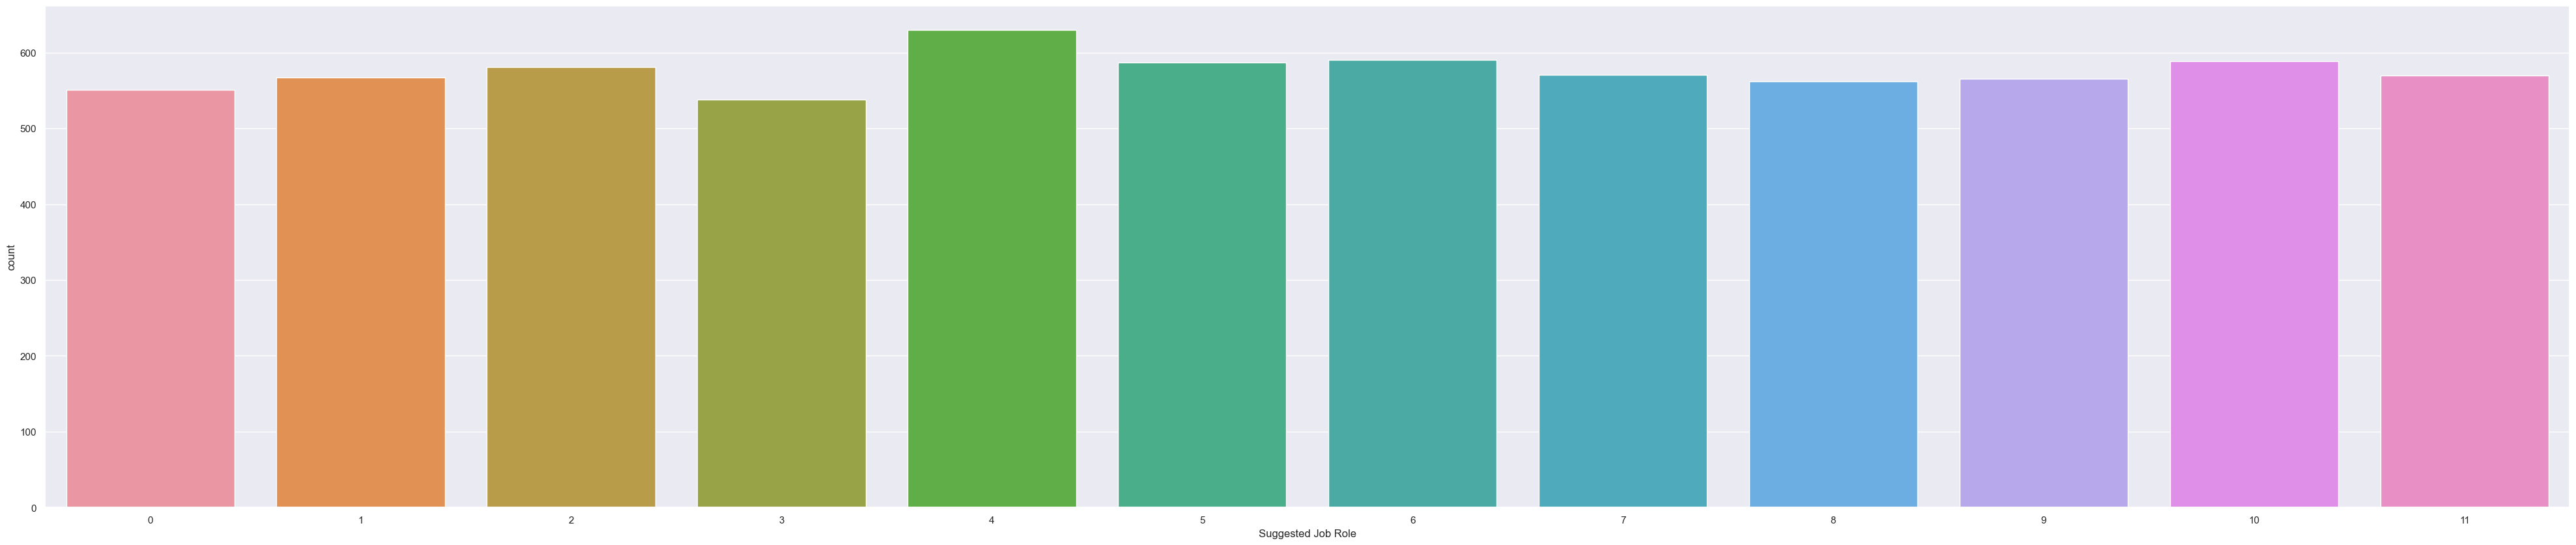

In [124]:
# Checking for data imbalanceness if any
sns.set(rc={'figure.figsize':(50,10)})
sns.countplot(x = df["Suggested Job Role"])